In [28]:
# ============================================
# SETUP - YOUR EXACT PATHS
# ============================================
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from tqdm import tqdm
from torchvision.models.resnet import ResNet
from typing import Optional 
from PIL import Image

# YOUR CONFIRMED PATHS
MODEL_PATH = 'person_a_baseline/results/model_weights/resnet18_baseline.pth'
DATA_PATH = 'data/'

print(f"✅ Model path: {MODEL_PATH}")
print(f"✅ Data path: {DATA_PATH}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"📱 Using device: {device}")

✅ Model path: person_a_baseline/results/model_weights/resnet18_baseline.pth
✅ Data path: data/
📱 Using device: cpu


In [15]:
# ============================================
# LOAD THE SAVED MODEL
# ============================================

# Create model architecture
def create_model(num_classes=102, model_init: ResNet = models.resnet18, weights: Optional[str] = None): # type: ignore
    """Recreate the ResNet18 model architecture"""
    model = model_init(weights=weights)  # No pretrained weights needed
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

# Initialize and load model
model = create_model(num_classes=102)
try:
    if os.path.exists(MODEL_PATH):
        model_state = torch.load(MODEL_PATH, map_location=device)
        model.load_state_dict(model_state)
        model = model.to(device)
        model.eval()
        print(f"✅ Model loaded successfully from: {MODEL_PATH}")
    else:
        print(f"❌ Model file not found at: {MODEL_PATH}")
        print("Please update the model_path variable with the correct path to your saved model.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model file exists and the path is correct.")

✅ Model loaded successfully from: person_a_baseline/results/model_weights/resnet18_baseline.pth


In [16]:
# ============================================
# LOAD EXISTING DATASET - NO DOWNLOAD
# ============================================

def get_data_transforms():
    """Get data transforms for evaluation"""

    # ImageNet dataset’s mean and standard deviation
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])
    
    return test_transform

# Load datasets from your existing data path
test_transform = get_data_transforms()

# IMPORTANT: download=False since data already exists
train_dataset = datasets.Flowers102(
    root=DATA_PATH,
    split='train',
    transform=test_transform,
    download=False  # DO NOT DOWNLOAD - USE EXISTING
)

val_dataset = datasets.Flowers102(
    root=DATA_PATH,
    split='val',
    transform=test_transform,
    download=False  # DO NOT DOWNLOAD - USE EXISTING
)

test_dataset = datasets.Flowers102(
    root=DATA_PATH, 
    split='test',
    transform=test_transform,
    download=False  # DO NOT DOWNLOAD - USE EXISTING
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=False, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=0
)

print(f"✅ Data loaded from existing path!")
print(f"📊 Dataset sizes:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

✅ Data loaded from existing path!
📊 Dataset sizes:
  Training: 1020 samples
  Validation: 1020 samples
  Test: 6149 samples


In [17]:
# ============================================
# MODEL STATISTICS
# ============================================

def count_parameters(model):
    """Count model parameters"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print("="*70)
print("MODEL ARCHITECTURE STATISTICS")
print("="*70)
print(f"Model: ResNet18 (Modified for 102 classes)")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size (MB): {total_params * 4 / 1024 / 1024:.2f}")
print(f"Input Size: 3 × 224 × 224")
print(f"Output Classes: 102")

MODEL ARCHITECTURE STATISTICS
Model: ResNet18 (Modified for 102 classes)
Total Parameters: 11,228,838
Trainable Parameters: 11,228,838
Model Size (MB): 42.83
Input Size: 3 × 224 × 224
Output Classes: 102


In [18]:
# ============================================
# EVALUATION FUNCTION
# ============================================

@torch.no_grad()
def evaluate_model(model, dataloader, device, desc="Evaluating"):
    """Evaluate model on a dataset"""
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probs = []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    for images, labels in tqdm(dataloader, desc=desc):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    predictions = np.array(all_predictions)
    labels = np.array(all_labels)
    probabilities = np.array(all_probs)
    
    accuracy = 100.0 * (predictions == labels).sum() / len(labels)
    avg_loss = total_loss / len(dataloader)
    
    return {
        'predictions': predictions,
        'labels': labels,
        'probabilities': probabilities,
        'accuracy': accuracy,
        'loss': avg_loss
    }

In [19]:
# ============================================
# EVALUATE ON ALL DATASETS
# ============================================

print("="*70)
print("EVALUATING MODEL PERFORMANCE")
print("="*70)

# Evaluate on all three sets
train_results = evaluate_model(model, train_loader, device, "Training Set")
val_results = evaluate_model(model, val_loader, device, "Validation Set")
test_results = evaluate_model(model, test_loader, device, "Test Set")

# Display results
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(f"📊 Training Accuracy:   {train_results['accuracy']:.2f}%")
print(f"📊 Validation Accuracy: {val_results['accuracy']:.2f}%")
print(f"📊 Test Accuracy:       {test_results['accuracy']:.2f}%")
print(f"\n⚠️ Overfitting Gap (Train-Test): {train_results['accuracy'] - test_results['accuracy']:.2f}%")

EVALUATING MODEL PERFORMANCE


Test Set: 100%|██████████| 193/193 [4:09:17<00:00, 77.50s/it]    


PERFORMANCE SUMMARY
📊 Training Accuracy:   99.90%
📊 Validation Accuracy: 82.55%
📊 Test Accuracy:       79.67%

⚠️ Overfitting Gap (Train-Test): 20.23%


In [29]:
def show_first_image_of_class(dataset, class_id, class_name):
	# Find first image index for the class
	idx = next(i for i, lbl in enumerate(dataset._labels) if lbl == class_id)

	# Load image from file
	img_path = dataset._image_files[idx]
	img = Image.open(img_path).convert("RGB")

	# Apply dataset transform if any
	if dataset.transform is not None:
		# To visualize, we want the *untransformed* version (so skip normalization)
		# comment out below line if you want to visualize the transformed tensor
		pass

	plt.imshow(img)
	plt.title(f"{class_name} (class {class_id})")
	plt.axis("off")
	plt.show()


ADVANCED METRICS (Test Set)
Top-1 Accuracy: 79.67%
Top-3 Accuracy: 90.42%
Top-5 Accuracy: 93.90%
Top-10 Accuracy: 96.85%

🎯 CONFIDENCE ANALYSIS:
  Average Confidence: 0.797
  Confidence when Correct: 0.878
  Confidence when Wrong: 0.480
  Confidence Gap: 0.398

🏆 TOP 5 BEST CLASSES:
  1. Class 7 (bird of paradise): 100.0%


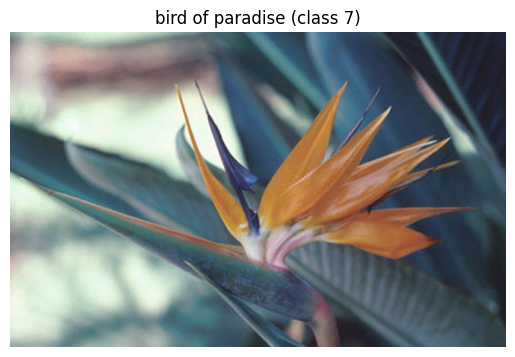

  2. Class 9 (globe thistle): 100.0%


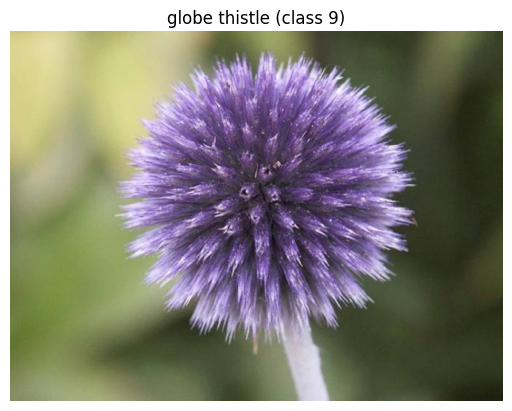

  3. Class 12 (king protea): 100.0%


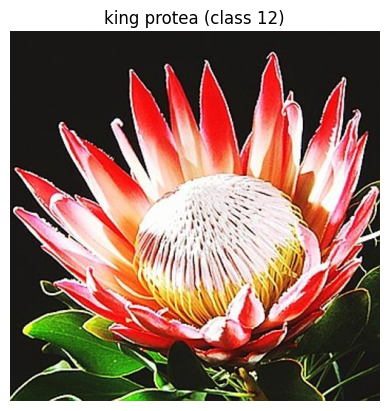

  4. Class 16 (purple coneflower): 100.0%


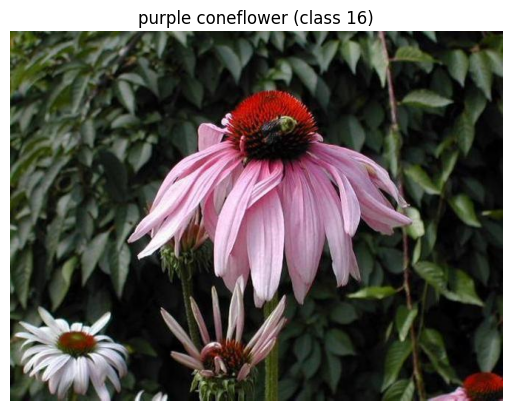

  5. Class 20 (fire lily): 100.0%


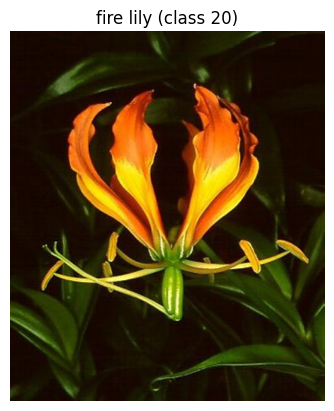


📉 TOP 5 WORST CLASSES:
  1. Class 89 (canna lily): 50.0%


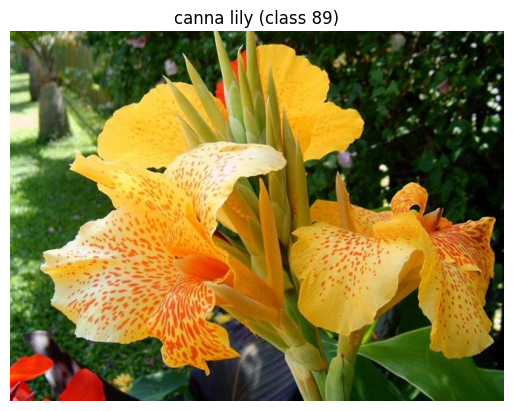

  2. Class 50 (petunia): 49.2%


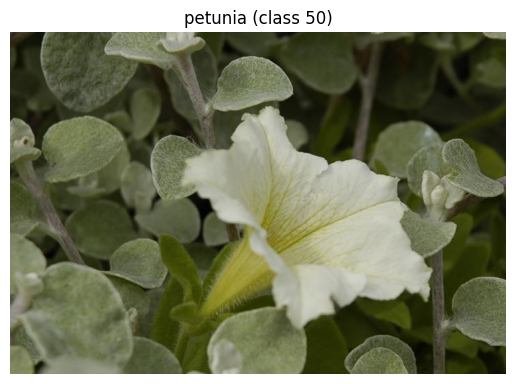

  3. Class 83 (columbine): 48.5%


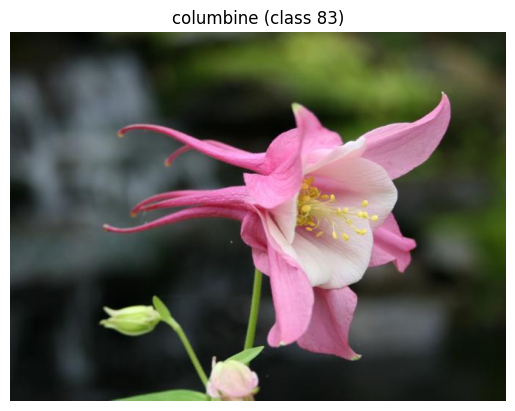

  4. Class 10 (snapdragon): 43.3%


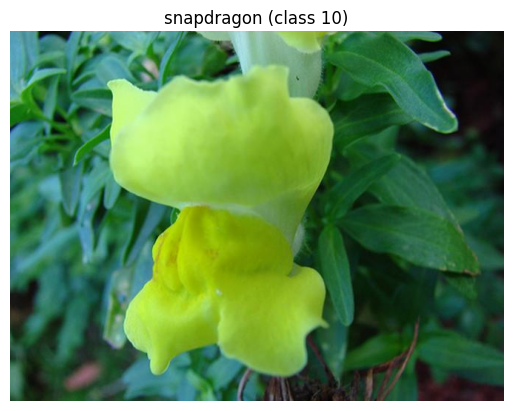

  5. Class 3 (sweet pea): 27.8%


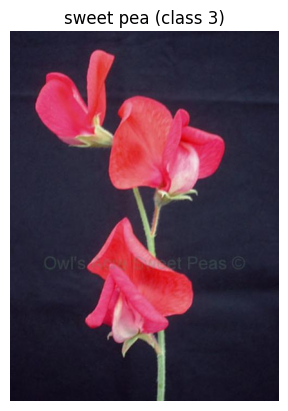

In [30]:
# ============================================
# ADVANCED METRICS
# ============================================

def calculate_topk_accuracy(probabilities, labels, k):
    """Calculate top-k accuracy"""
    top_k_correct = 0
    for i in range(len(labels)):
        top_k_preds = np.argsort(probabilities[i])[-k:][::-1]
        if labels[i] in top_k_preds:
            top_k_correct += 1
    return 100.0 * top_k_correct / len(labels)

print("\n" + "="*70)
print("ADVANCED METRICS (Test Set)")
print("="*70)

# Top-K accuracies
topk_results = {}
for k in [1, 3, 5, 10]:
    topk_acc = calculate_topk_accuracy(
        test_results['probabilities'], 
        test_results['labels'], 
        k
    )
    topk_results[k] = topk_acc
    print(f"Top-{k} Accuracy: {topk_acc:.2f}%")

# Confidence analysis
predictions = test_results['predictions']
labels = test_results['labels']
probabilities = test_results['probabilities']

confidence_scores = probabilities[np.arange(len(predictions)), predictions]
correct_mask = predictions == labels

avg_confidence = confidence_scores.mean()
avg_conf_correct = confidence_scores[correct_mask].mean()
avg_conf_wrong = confidence_scores[~correct_mask].mean()

print(f"\n🎯 CONFIDENCE ANALYSIS:")
print(f"  Average Confidence: {avg_confidence:.3f}")
print(f"  Confidence when Correct: {avg_conf_correct:.3f}")
print(f"  Confidence when Wrong: {avg_conf_wrong:.3f}")
print(f"  Confidence Gap: {avg_conf_correct - avg_conf_wrong:.3f}")

# Per-class accuracy
class_correct = {}
class_total = {}
for i in range(102):
    mask = labels == i
    if mask.sum() > 0:
        class_total[i] = mask.sum()
        class_correct[i] = (predictions[mask] == i).sum()

class_accuracies = [(i, 100.0 * class_correct[i] / class_total[i]) 
                   for i in class_correct.keys()]
class_accuracies.sort(key=lambda x: x[1], reverse=True)

flower_classes = test_dataset.classes
print(f"\n🏆 TOP 5 BEST CLASSES:")
for i, (class_id, acc) in enumerate(class_accuracies[:5], 1):
    class_name = flower_classes[class_id]
    print(f"  {i}. Class {class_id} ({class_name}): {acc:.1f}%")
    show_first_image_of_class(test_dataset, class_id, class_name)

print(f"\n📉 TOP 5 WORST CLASSES:")
for i, (class_id, acc) in enumerate(class_accuracies[-5:], 1):
    class_name = flower_classes[class_id]
    print(f"  {i}. Class {class_id} ({class_name}): {acc:.1f}%")
    show_first_image_of_class(test_dataset, class_id, class_name)